In [60]:
import sys, os



%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import os
os.environ['R_HOME'] = 'D:/Program Files/R-4.5.0' #@TODO include in some setup file

from simulation_engine.scenarios.iv.binary_iv import BinaryIV
from simulation_engine.scenarios.iv.continuous_iv import ContinuousIV
from simulation_engine.scenarios.iv.base_iv import IVScenario
from simulation_engine.util.plotting_util import PlottingUtil
from simulation_engine.algorithms.causaloptim import Causaloptim
from simulation_engine.algorithms.zhang_bareinboim import ZhangBareinboim
from simulation_engine.algorithms.apid import Apid
from simulation_engine.algorithms.apid_src.src.models.apid import APID

import pandas as pd
pd.set_option('display.max_columns', None)

#disable warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from simulation_engine.algorithms.zaffalonbounds import ZaffalonBounds
from hydra import compose, initialize
from omegaconf import OmegaConf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# ContinousIV Test

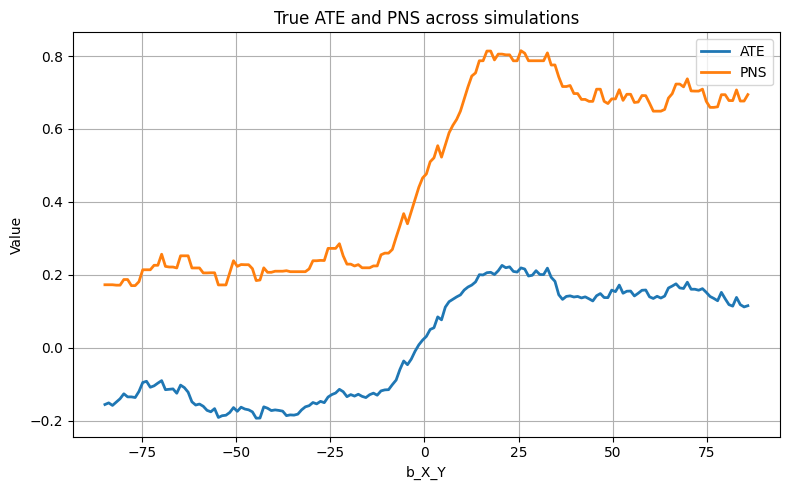

In [3]:
function_keys = [
                "identity",
                "sin",
                "cos",
                "tanh",
                "log1p_abs",
                "exp_neg_sq",
                "sigmoid",
                "exp_clipped"
            ]

data = ContinuousIV.run_rolling_b_X_Y_simulations(
    b_range=(-100, 100), N_points=200, replications=1, n=500,
)
PlottingUtil.plot_ate_pns(data,window=30)

In [56]:
data = ContinuousIV.run_rolling_b_X_Y_simulations(
        b_range=(3, 10), N_points=1, replications=1, n=500,
        allowed_functions=['identity'])

contIV = ContinuousIV('IV DAG', data)
data = contIV.binaryIV.data

row_dicts = [row.to_dict() for _, row in data.iterrows()]
ZaffalonBounds._run_zaffalon_from_row_dict(row_dicts[0], 'ATE')



Zaffalon result: 0.0022,0.4908


{'ATE_zaffalonbounds_bound_lower': 0.0022,
 'ATE_zaffalonbounds_bound_upper': 0.4908,
 'ATE_zaffalonbounds_bound_valid': True,
 'ATE_zaffalonbounds_bound_width': 0.48860000000000003,
 'ATE_zaffalonbounds_bound_failed': False}

In [ ]:
data = BinaryIV.generate_data_rolling_ate(1)
binaryIV = BinaryIV('IV Dag', data)
binaryIV.data

0    [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, ...
Name: Z, dtype: object

In [59]:
data = ContinuousIV.run_rolling_b_X_Y_simulations(
        b_range=(3, 10), N_points=1, replications=1, n=500,
        allowed_functions=['identity'])

algs = ['ATE_zaffalonbounds-binned']
contIV = ContinuousIV('IV Dag', data)
contIV.run()
contIV.binaryIV.data


Running ATE_zhangbareinboim...
ATE_zhangbareinboim completed in 0.60 seconds.
Running ATE_causaloptim-binned...
Entering binned Binary IV Scenario for algorithm: ATE_causaloptim
Running ATE_causaloptim...
ATE_causaloptim completed in 9.00 seconds.
Total runtime: 9.00 seconds.
Exiting binned Binary IV Scenario.
ATE_causaloptim-binned completed in 9.00 seconds.
Running ATE_autobound-binned...
Entering binned Binary IV Scenario for algorithm: ATE_autobound
Running ATE_autobound...
Error in AutoBound: Command '['D:\\Programme\\anaconda\\envs\\py312\\Library\\bin\\glpsol.exe', '--version']' timed out after 2 seconds


UnboundLocalError: cannot access local variable 'bound_upper' where it is not associated with a value

In [7]:
algs = contIV.get_algorithms('ATE')
PlottingUtil.print_bound_statistics_table(contIV.data, algs)
PlottingUtil.plot_smoothed_query_vs_bounds(contIV.data, 'ATE', algs, 5)

                Algorithm Fail Rate (%) Invalid Rate (%) Net Bound Width Bound Width
      ATE_zhangbareinboim           N/A              N/A             N/A         NaN
   ATE_causaloptim-binned           N/A              N/A             N/A         NaN
     ATE_autobound-binned           N/A              N/A             N/A         NaN
ATE_zaffalonbounds-binned        100.00              nan             nan      2.0000
            ATE_2SLS-0.99           N/A              N/A             N/A         NaN
            ATE_2SLS-0.98           N/A              N/A             N/A         NaN
            ATE_2SLS-0.95           N/A              N/A             N/A         NaN
Error: The 'b_X_Y' column has constant or invalid values. Cannot plot.


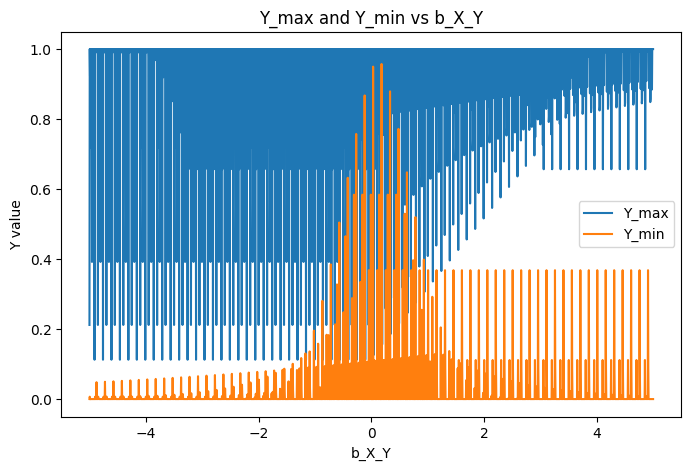

In [107]:
import matplotlib.pyplot as plt

y_label = 'Y'
plt.figure(figsize=(8, 5))
plt.plot(data['b_X_Y'], data[f'{y_label}_max'], label=f'{y_label}_max')
plt.plot(data['b_X_Y'], data[f'{y_label}_min'], label=f'{y_label}_min')
# plt.plot(data['b_X_Y'], data[f'{y_label}_mean'], 'o-', label=f'{y_label}_mean')
plt.xlabel('b_X_Y')
plt.ylabel(f'{y_label} value')
plt.title(f'{y_label}_max and {y_label}_min vs b_X_Y')
plt.legend()
plt.show()

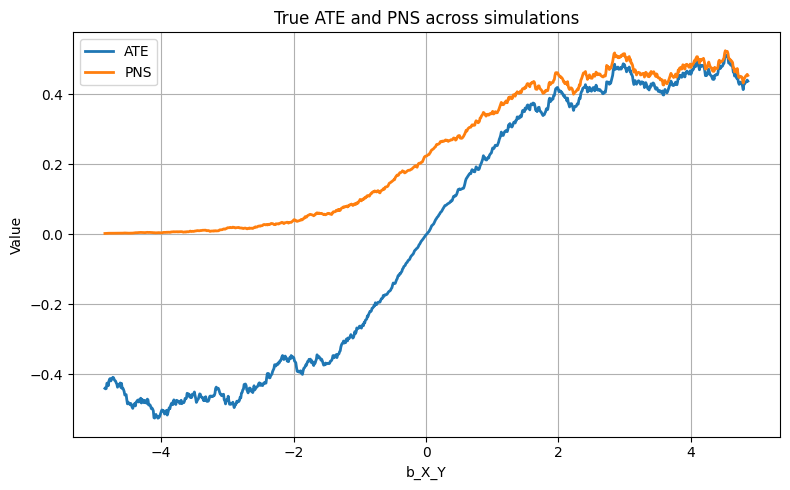

In [49]:
data = BinaryIV.generate_data_rolling_ate(1000, b_lower=-5, b_upper=5)

PlottingUtil.plot_ate_pns(data, window=30)

In [12]:
data = BinaryIV.generate_data_rolling_ate(1)
binaryIV = BinaryIV('IV Dag', data)
algs = ['ATE_zaffalonbounds']

algorithms = [alg for alg in binaryIV.get_algorithms('ATE') if 'zaffalonbounds' not in alg]
algorithms
runtimes = binaryIV.run(algs)
binaryIV.data

Running ATE_zaffalonbounds...
ATE_zaffalonbounds completed in 17.85 seconds.
Total runtime: 17.85 seconds.


,seed,intercept_X,intercept_Y,b_Z_X,b_U_X,b_X_Y,b_U_Y,ATE_true,PNS_true,p_Y1_mean,p_Y0_mean,p_U,p_Z,Z,U,X,Y,entropy_Z,entropy_U,entropy_X,entropy_Y,sigma_X,sigma_Y,squasher_X_name,squasher_Y_name,ATE_zaffalonbounds_bound_lower,ATE_zaffalonbounds_bound_upper,ATE_zaffalonbounds_bound_valid,ATE_zaffalonbounds_bound_width,ATE_zaffalonbounds_bound_failed
0,788135,0,0,0.096184,-0.207559,-5.0,-0.506499,-0.332318,0.002963,0.004521,0.336839,0.81601,0.088091,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...","[1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...","[1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...",0.493854,0.68875,0.995829,0.697269,0.143393,0.42579,probit,softplus,-0.4673,-0.0045,True,0.4628,False


In [15]:
algorithms = list(runtimes['runtimes'].keys())
ate_algs = binaryIV.get_algorithms('ate')
# PlottingUtil.print_bound_statistics(binaryIV.data, ate_algs)
PlottingUtil.print_bound_statistics_table(binaryIV.data, algs)
PlottingUtil.plot_smoothed_query_vs_bounds(binaryIV.data, 'ATE', algs, 5, False)

         Algorithm Fail Rate (%) Invalid Rate (%) Net Bound Width Bound Width
ATE_zaffalonbounds          0.00             0.00          0.5236      0.5236
Error: The 'b_X_Y' column has constant or invalid values. Cannot plot.
